# Import the libraries

In [1]:
!pip install imbalanced-learn
!pip install contractions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re, string, unicodedata
from bs4 import BeautifulSoup


import nltk
import contractions

nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

from imblearn.over_sampling import SMOTE


[nltk_data] Downloading package wordnet to /Users/zwtao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zwtao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
for dirname, _, filenames in os.walk('twitter-airline-sentiment'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

twitter-airline-sentiment/database.sqlite
twitter-airline-sentiment/Tweets.csv


# Load data 

In [4]:
# loading data
data = pd.read_csv('twitter-airline-sentiment/Tweets.csv')

# Data Pretreatment

In [5]:
data.shape

(14640, 15)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [8]:
data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Checking if data is duplicated and removing duplicates

In [9]:
# Check for duplicate rows
duplicateRowsDF = data[data.duplicated()]
print(duplicateRowsDF.head())
print(duplicateRowsDF.shape)  

                 tweet_id airline_sentiment  airline_sentiment_confidence  \
12040  570308309682675712          negative                           1.0   
12059  570305051819941889           neutral                           1.0   
12063  570303383782989824           neutral                           1.0   
12066  570301929580048385           neutral                           1.0   
12068  570301395141836801          negative                           1.0   

               negativereason  negativereason_confidence   airline  \
12040  Customer Service Issue                        1.0  American   
12059                     NaN                        NaN  American   
12063                     NaN                        NaN  American   
12066                     NaN                        NaN  American   
12068             Late Flight                        1.0  American   

      airline_sentiment_gold            name negativereason_gold  \
12040                    NaN      SweeLoTmac    

In [10]:
# Drop the duplicate rows
data.drop_duplicates(keep=False,inplace=True) 
data.shape

(14568, 15)

In [11]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.456800e+04,14568.000000,10484.000000,14568.000000
mean,5.692131e+17,0.899675,0.636987,0.082921
std,7.773880e+14,0.163080,0.330318,0.747520
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685551e+17,0.691975,0.360300,0.000000
50%,5.694655e+17,1.000000,0.670400,0.000000
75%,5.698859e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Explorotary data Analysis EDA

Sentiment Analysis for each Airline 

Here we can see that United Airlines, US Airways, American Airlines has the most number of negative review

Virgin America has the least number of negative reviews

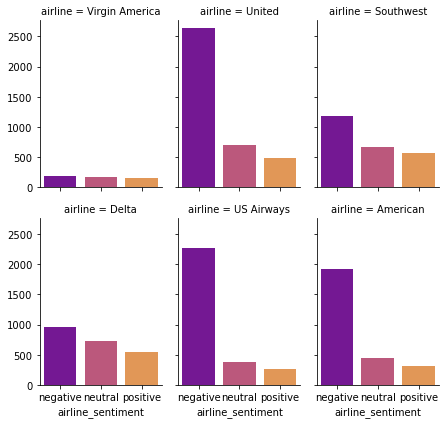

In [12]:
graphs = sns.FacetGrid(data, col="airline", col_wrap=3, height=3, aspect=0.7)
graphs = graphs.map(sns.countplot, "airline_sentiment",order =data.airline_sentiment.value_counts().index, palette='plasma')
plt.show()


### Most Common negative review reasons

Customer Service Issue         2898
Late Flight                    1655
Can't Tell                     1190
Cancelled Flight                839
Lost Luggage                    718
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     479
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


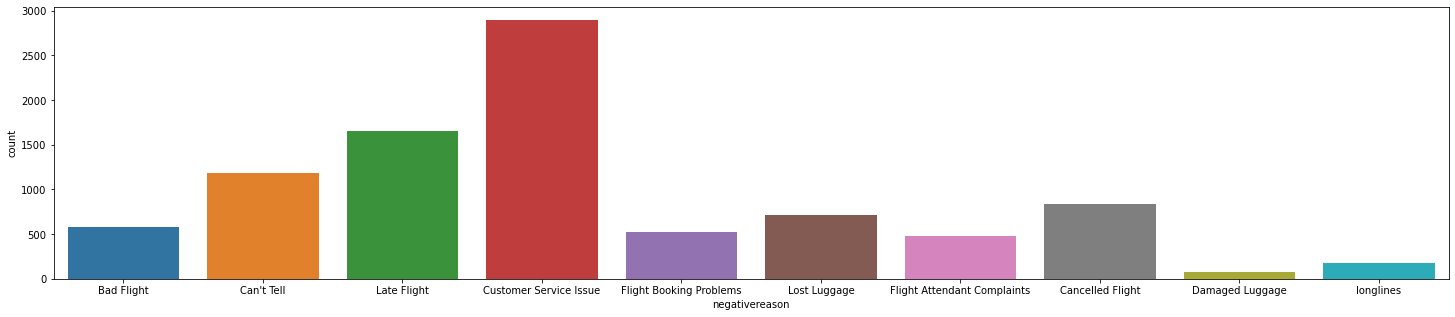

In [13]:
# Check the most common negative reason 
y = data['negativereason']
print(y.value_counts())
plt.figure(figsize=(25,5)) 
g = sns.countplot(y)
# Customer service and Late flight seems to be the main reason why customers are giving bad feedback

## Drop Irrelevant columns

In [14]:
# Remove redundant columns
df = data.drop(columns=['tweet_id', 'airline_sentiment_confidence', 
                        'negativereason', 'negativereason_confidence', 
                        'airline', 'airline_sentiment_gold', 'name', 
                        'negativereason_gold', 'tweet_coord','tweet_location',
                        'user_timezone', 'tweet_created', 'retweet_count'], axis=1)
# df = data.drop(columns=['tweet_id', 'negativereason', 'airline', 
#                            'airline_sentiment_gold', 'name',
#                            'negativereason_gold', 'tweet_coord', 
#                            'tweet_created', 'tweet_location', 
#                             'user_timezone', 'negativereason_confidence'], axis=1)

df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [15]:
df['text'][220]

'@VirginAmerica had to change to another airline to get to DC today ... Why is @united able to land in DC but not you? Cost me $800 ...ugh'

In [16]:
df.airline_sentiment.value_counts()

negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64

In [17]:
#find is there null value
df.isnull().sum()[lambda x: x>0]

Series([], dtype: int64)

## Is the data balanced

negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64


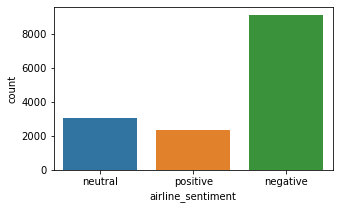

In [18]:
y = df['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(5,3)) 
g = sns.countplot(y)
# No, Here we can see that the data is not balanced, There are lot of negative sentiments

# Text pre-processing: Data preparation.

In [19]:
def perform_html_cleanup( raw_review ):
  # 1. Remove HTML
  review_text = BeautifulSoup(raw_review).get_text()
  return review_text

In [20]:
def replace_contractions(raw_review):
    #Replace contractions in raw_review
    return contractions.fix(raw_review)

In [21]:
def perform_tokenization( raw_review ):
  # 2. Perform Tokenization
  word_tokens = word_tokenize(raw_review)  # Tokenization
  return word_tokens

In [22]:
def remove_numbers(list_of_words): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

In [23]:
def remove_special_character_punctuation(list_of_words): 
    pattern = '[^A-Za-z0-9]+'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

In [24]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

In [25]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

In [26]:
def remove_empty_string(words):
  return list(filter(None, words))

In [27]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []                            # Create empty list to store pre-processed words.
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)                # Append processed words to new list.
    return stems

In [28]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

In [29]:
stop_words = ['thank', 'thanks', 'thank you', 'u', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### Pre-processing

In [30]:
def perform_cleanup(raw_review):
    clean_review = perform_html_cleanup(raw_review)
    clean_review = replace_contractions(clean_review)
    clean_review = perform_tokenization(clean_review)
    clean_review = remove_numbers(clean_review)
    clean_review = remove_special_character_punctuation(clean_review)
    clean_review = remove_punctuation(clean_review)
    clean_review  = to_lowercase(clean_review)
    clean_review = remove_empty_string(clean_review)
    #clean_review = stem_words(clean_review)
    clean_review = lemmatize_verbs(clean_review)
    return clean_review

In [31]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [32]:
clean_reviews = []

for i, row in df.iterrows():
    words = df.at[i, 'text']
    words = perform_cleanup(words)
    df.at[i,'text'] = " ".join( words )
    clean_reviews.append( df.at[i, 'text'] )
df.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica it be really aggressive to blast...
4,negative,virginamerica and it be a really big bad thing...


In [33]:
df['text'][220]

'virginamerica have to change to another airline to get to dc today why be unite able to land in dc but not you cost me ugh'

### CountVectorizer

In [34]:
print ("Creating the bag of words...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
count_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
count_vectorizer_data_features = count_vectorizer.fit_transform(clean_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
count_vectorizer_data_features = count_vectorizer_data_features.toarray()

Creating the bag of words...



In [35]:
print (count_vectorizer_data_features.shape)
print('The vector is: ')
print(count_vectorizer_data_features)

(14568, 5000)
The vector is: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
count_vectorizer_data_features[220]

array([0, 0, 0, ..., 0, 0, 0])

#### Vocabulary

In [37]:
# Take a look at the words in the vocabulary
count_vectorizer_vocab = count_vectorizer.get_feature_names()
print (count_vectorizer_vocab)


['aa', 'aacom', 'aadv', 'aadvantage', 'aafail', 'aal', 'aano', 'aarp', 'abandon', 'abc', 'abcnetwork', 'abilities', 'ability', 'able', 'aboard', 'about', 'above', 'abq', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'abuse', 'abysmal', 'ac', 'accept', 'acceptable', 'access', 'accident', 'accidentally', 'accommodate', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'acct', 'accts', 'accurate', 'accuse', 'achieve', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acquire', 'acquisition', 'across', 'act', 'action', 'activate', 'active', 'activitiesprevention', 'actual', 'actually', 'ad', 'adam', 'add', 'addition', 'additional', 'address', 'addtl', 'adjacent', 'admiral', 'admirals', 'admit', 'adopt', 'adore', 'ads', 'adult', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisories', 'advisory', 'aerojobmarket', 'affect', 'affiliate', 'afford', 'affordable', 'afraid', 'after', 'afterall', 'afternoon', 'again', 'against',

In [38]:
count_vectorizer_vocab[220]

'ap'

#### Stop words

In [39]:
count_vectorizer_stop_words = count_vectorizer.get_stop_words()
print (count_vectorizer_stop_words)
# There are no stop words since we are doing sentiment analysis

None


In [40]:
# Sum up the counts of each vocabulary word
dist = np.sum(count_vectorizer_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(count_vectorizer_vocab, dist):
    print (count, tag)

274 aa
3 aacom
2 aadv
10 aadvantage
2 aafail
2 aal
2 aano
3 aarp
3 abandon
8 abc
3 abcnetwork
2 abilities
5 ability
119 able
4 aboard
509 about
18 above
9 abq
2 abroad
22 absolute
30 absolutely
13 absurd
7 abt
3 abuse
6 abysmal
9 ac
32 accept
23 acceptable
39 access
5 accident
4 accidentally
26 accommodate
8 accommodations
4 accomplish
11 accord
4 accordingly
80 account
6 accountability
2 accrue
11 acct
2 accts
10 accurate
2 accuse
3 achieve
4 acknowledge
2 acknowledgement
2 acknowledgment
2 acquire
2 acquisition
16 across
18 act
13 action
2 activate
4 active
2 activitiesprevention
21 actual
86 actually
4 ad
2 adam
126 add
4 addition
17 additional
52 address
3 addtl
2 adjacent
5 admiral
12 admirals
6 admit
6 adopt
2 adore
5 ads
2 adult
14 advance
15 advantage
11 advertise
9 advice
20 advise
2 advisories
24 advisory
2 aerojobmarket
15 affect
3 affiliate
13 afford
3 affordable
2 afraid
467 after
2 afterall
30 afternoon
391 again
6 against
15 age
6 agency
258 agent
155 agents
3 aggravate


18 dragons
2 dramatically
5 draw
2 dre
2 dread
13 dream
2 dreamliner
2 dress
47 drink
76 drive
6 driver
62 drop
4 drunks
5 dry
4 dsm
8 dtw
3 dublin
3 dude
240 due
3 duffle
4 duh
12 dull
4 dullesairport
2 dultch
8 dumb
5 dump
4 dunno
2 dupe
3 durango
59 during
4 duty
50 each
2 eagle
2 ear
93 earlier
2 earliest
97 early
3 earlybird
26 earn
6 earth
2 earthquake
12 easier
4 easiest
13 easily
13 east
8 eastern
36 easy
18 eat
2 eb
3 eco
3 econ
15 economy
2 ed
2 edinburgh
2 edit
3 educate
2 education
2 educational
5 efficiency
4 efficient
12 effort
6 efforts
2 eh
2 eight
42 either
3 el
2 elaborate
4 elderly
10 elevate
2 eligible
14 elite
2 eliz
5 ella
3 ellahenderson
2 elm
60 else
9 elsewhere
285 email
16 embarrass
2 embarrassment
2 embassy
4 emboss
2 embraersa
2 emerald
18 emergency
2 emp
2 empathize
3 empathy
2 employ
36 employee
85 employees
2 employer
46 empty
2 ems
2 emv
6 en
5 encounter
2 encourage
72 end
3 endless
2 endlessly
2 energy
3 enforce
2 engage
18 engine
9 english
33 enjoy
3 e

5 lunch
2 lusaka
3 luvswa
2 luxurious
3 lynn
2 maatkare
2 mac
8 machine
16 mad
2 madam
4 madness
4 madrid
5 magazine
5 magic
2 magically
4 maiden
17 mail
3 maimi
17 main
2 maine
6 maint
3 maintain
53 maintenance
22 major
691 make
2 makeup
7 male
8 malfunction
2 mammoth
29 man
20 manage
13 management
13 manager
3 managers
3 manch
4 manchester
2 mandarinjourney
2 maneuver
6 manner
3 manners
4 manually
105 many
6 map
3 marathon
27 march
3 mardigras
2 maria
4 marie
16 mark
17 market
2 marriott
5 marry
2 marshal
2 martysg
4 mary
2 maryellagreen
3 mass
5 massive
3 mastercard
2 mat
21 match
3 math
35 matter
2 maui
2 max
67 may
78 maybe
2 maysep
3 mayweatherpacquiao
3 mc
3 mce
10 mci
43 mco
5 md
13 mdw
1919 me
23 meal
10 meals
105 mean
2 meaningful
3 meantime
2 meanwhile
4 measure
7 mech
2 mechanic
69 mechanical
12 mechanics
2 medal
37 media
9 medical
4 meds
2 meelan
56 meet
2 meh
2 mel
6 mem
54 member
35 members
8 membership
2 memo
2 memorial
5 memories
3 memory
12 memphis
3 men
26 mention
4 

8 segment
31 select
4 selection
2 selections
4 self
8 selfie
2 selfies
2 selfservice
40 sell
320 send
2 senior
33 sense
3 sensitive
3 sentiment
2 sentinel
13 separate
3 separately
5 sept
5 september
3 series
17 serious
79 seriously
2 seriousness
7 serv
26 serve
992 service
4 servicefail
40 set
5 settle
2 setup
4 seven
34 several
4 severe
4 severely
4 sexual
2 sexy
14 sf
110 sfo
2 sfofll
1 sfojfk
2 sfolax
1 sfolaxsalclo
1 sfoord
1 sfopdx
1 sfosea
1 sfotobos
1 sfoyyj
1 sgf
1 sh
3 shade
1 shadier
1 shady
2 shaft
3 shake
1 shaker
1 shaky
4 shall
1 sham
15 shame
11 shameful
2 shameonyou
2 shampoo
2 shanghai
4 shannon
2 shannonwoodward
52 share
2 shawn
249 she
2 sheesh
2 shenanigans
4 shift
2 shin
8 ship
3 shirt
36 shit
1 shitshow
10 shitty
1 shittydeal
1 shivadelrahim
1 shiver
1 shiz
2 shld
16 shock
1 shocker
2 shoddy
9 shoe
15 shoot
7 shop
28 short
2 shortage
2 shortcomings
9 shortly
3 shots
370 should
5 shoulder
1 shouldhavedriven
3 shouldhaveflowndelta
1 shouldhaveflownjetblue
1 shouldig

### TfidfVectorizer

In [ ]:
# Initialize the "TfidfVectorizer" object
# Convert a collection of raw documents to a matrix of TF-IDF features.
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             min_df=5, 
                             max_df=0.7,
                             ngram_range=(1,2)) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(clean_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()

In [ ]:
print (tfidf_vectorizer_data_features.shape)
print(tfidf_vectorizer_data_features)

In [ ]:
tfidf_vectorizer_vocab = tfidf_vectorizer.get_feature_names()
print (tfidf_vectorizer_vocab)

In [ ]:
# Sum up the counts of each vocabulary word
tf_df_dist = np.sum(tfidf_vectorizer_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(tfidf_vectorizer_vocab, tf_df_dist):
    print (count, tag)

## Fit and evaluate model using both countVectorizer
### Data Splite

In [41]:
x = count_vectorizer_data_features     # Predictor feature columns
y = data['airline_sentiment']   # Predicted class

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1234)  # 1 is just any random seed number

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9760, 5000)
(9760,)
(4808, 5000)
(4808,)


### Applying SMOTE since the data is not balanced

In [43]:
smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(x_train, y_train)

In [44]:
print(X_train_SMOTE.shape)
print(y_train_SMOTE.shape)


(18312, 5000)
(18312,)


In [45]:
y_train_SMOTE

0        negative
1        negative
2        negative
3        positive
4         neutral
           ...   
18307    positive
18308    positive
18309    positive
18310    positive
18311    positive
Name: airline_sentiment, Length: 18312, dtype: object

### Checking if data is balanced after applying SMOTE

negative    6104
neutral     6104
positive    6104
Name: airline_sentiment, dtype: int64


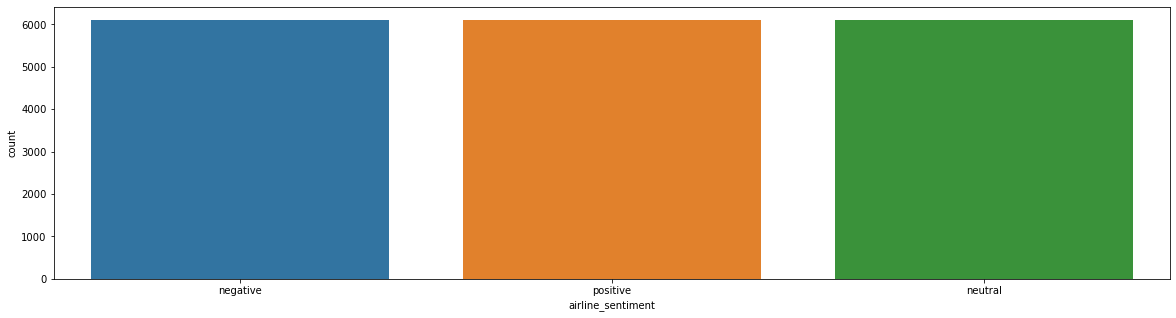

In [46]:
after_smote_airline_sentiment=pd.DataFrame(y_train_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)
# Here we can see that after applying smote, the data is balanced

### Dividing Test data to Test and Validation Data

In [47]:
# Dividing the test data into test and validation set in 50-50 ratio
x_test_main, x_validation, y_test_main, y_validation = train_test_split(x_test, y_test, test_size=0.50, random_state=1)

print(x_validation.shape)
print(x_test_main.shape)


print(y_validation.shape)
print(y_test_main.shape)

# There are 2185 samples for validation and 2186 samples for testing

(2404, 5000)
(2404, 5000)
(2404,)
(2404,)


### Baseline: Decision Tree

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
# preset the choosed parameters
max_depth = [2,3,4,5,6,7,8]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]

DT_parameters = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
DT_parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'min_samples_split': [2, 4, 6, 8],
 'min_samples_leaf': [2, 4, 8, 10, 12]}

In [72]:
# Gridsearch to find the best parameters
DT_Model = GridSearchCV(estimator = tree.DecisionTreeClassifier(), param_grid = DT_parameters, cv=10)
# model fit
DT_Model.fit(x_test_main, y_test_main)
# Print best params
print('\nBest parameters:', DT_Model.best_params_)

print('\nClassification report of decision tree:\n')
print(classification_report(y_test_main, DT_Model.predict(x_test_main)))



Best parameters: {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2}

Classification report of decision tree:

              precision    recall  f1-score   support

    negative       0.76      0.93      0.84      1522
     neutral       0.54      0.33      0.41       489
    positive       0.68      0.41      0.51       393

    accuracy                           0.73      2404
   macro avg       0.66      0.56      0.59      2404
weighted avg       0.70      0.73      0.70      2404



In [73]:
params = {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2, 'random_state': 1234}
DT = tree.DecisionTreeClassifier(**params)
DT.fit(X_train_SMOTE, y_train_SMOTE)
DT_pred = DT.predict(x_test_main)
DT_accuracy = metrics.accuracy_score(y_test_main, DT_pred)
print('The accuracy on test：\n',DT_accuracy)

The accuracy on test：
 0.6622296173044925


#### Training

In [74]:
# Make class predictions for the Validation set
y_validation_predict= DT.predict(x_validation)

# Training and Validation Accuracy
print("Trainig accuracy",DT.score(X_train_SMOTE,y_train_SMOTE))  
print()
print("Validation accuracy",DT.score(x_validation, y_validation))
print()

Trainig accuracy 0.6536697247706422

Validation accuracy 0.6480865224625624



In [75]:
#get scores
print('\nClassification report of Decision Tree:\n')
print(classification_report(y_train_SMOTE, DT.predict(X_train_SMOTE)))


Classification report of Decision Tree:

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74      6104
     neutral       0.53      0.77      0.63      6104
    positive       0.87      0.43      0.58      6104

    accuracy                           0.65     18312
   macro avg       0.71      0.65      0.65     18312
weighted avg       0.71      0.65      0.65     18312



#### Testing 

In [76]:
print("Testing accuracy",DT.score(x_test_main, y_test_main))
print()
print(classification_report(y_test_main, DT.predict(x_test_main)))

Testing accuracy 0.6622296173044925

              precision    recall  f1-score   support

    negative       0.81      0.75      0.78      1522
     neutral       0.38      0.60      0.46       489
    positive       0.71      0.39      0.50       393

    accuracy                           0.66      2404
   macro avg       0.63      0.58      0.58      2404
weighted avg       0.71      0.66      0.67      2404



Cross Validation

In [77]:
# Evaluate score by cross-validation
print (np.mean(cross_val_score(DT,X_train_SMOTE, y_train_SMOTE,cv=10)))

0.6426473709691651


### RandomForestClassifier

#### Training data 

In [101]:
max_depth = [2,3,4,5,6,7,8]

RT_parameters = {'max_depth':max_depth}
RT_parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8]}

In [102]:
# Gridsearch to find the best parameters
RT_Model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RT_parameters, cv=10)
# model fit
RT_Model.fit(x_test_main, y_test_main)
# Print best params
print('\nBest parameters:', RT_Model.best_params_)

print('\nClassification report of decision tree:\n')
print(classification_report(y_test_main, RT_Model.predict(x_test_main)))



Best parameters: {'max_depth': 8}

Classification report of decision tree:

              precision    recall  f1-score   support

    negative       0.63      1.00      0.78      1522
     neutral       0.00      0.00      0.00       489
    positive       0.00      0.00      0.00       393

    accuracy                           0.63      2404
   macro avg       0.21      0.33      0.26      2404
weighted avg       0.40      0.63      0.49      2404



In [103]:
# Initialize a Random Forest classifier with 100 trees
params = {'max_depth': 8, 'random_state': 1234}
randomforestclassifier = RandomForestClassifier(**params) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable

print ("Training the random forest...")
randomforestclassifier = randomforestclassifier.fit( X_train_SMOTE, y_train_SMOTE)


Training the random forest...


In [104]:
print('\nClassification report of Random forest:\n')
randomforestclassifier.score(X_train_SMOTE, y_train_SMOTE)


Classification report of Random forest:



0.7228593272171254

In [105]:
# Make class predictions for the Validation set
y_validation_predict= randomforestclassifier.predict(x_validation)

In [106]:
# Training and Validation Accuracy
print("Trainig accuracy",randomforestclassifier.score(X_train_SMOTE,y_train_SMOTE))  
print()
print("Validation accuracy",randomforestclassifier.score(x_validation, y_validation))
print()

Trainig accuracy 0.7228593272171254

Validation accuracy 0.7325291181364393



In [107]:
print(classification_report(y_train_SMOTE, randomforestclassifier.predict(X_train_SMOTE)))

              precision    recall  f1-score   support

    negative       0.76      0.90      0.82      6104
     neutral       0.68      0.58      0.62      6104
    positive       0.72      0.69      0.70      6104

    accuracy                           0.72     18312
   macro avg       0.72      0.72      0.72     18312
weighted avg       0.72      0.72      0.72     18312



In [108]:
# Evaluate score by cross-validation
print (np.mean(cross_val_score(randomforestclassifier,X_train_SMOTE, y_train_SMOTE,cv=10)))

0.7045243072366021


#### Classification Report (Validation Set)

In [87]:
print(classification_report(y_validation, randomforestclassifier.predict(x_validation)))

              precision    recall  f1-score   support

    negative       0.81      0.90      0.86      1514
     neutral       0.56      0.47      0.51       489
    positive       0.67      0.54      0.60       401

    accuracy                           0.75      2404
   macro avg       0.68      0.64      0.66      2404
weighted avg       0.74      0.75      0.74      2404



#### Testing data 

In [88]:
print("Testing accuracy",randomforestclassifier.score(x_test_main, y_test_main))

Testing accuracy 0.7454242928452579


#### Classification Report (Test Set)

In [89]:
# Make class predictions for the Validation set
y_test_predict= randomforestclassifier.predict(x_test_main)

print(classification_report(y_test_main,y_test_predict))

              precision    recall  f1-score   support

    negative       0.82      0.89      0.85      1522
     neutral       0.55      0.47      0.51       489
    positive       0.63      0.52      0.57       393

    accuracy                           0.75      2404
   macro avg       0.67      0.63      0.64      2404
weighted avg       0.73      0.75      0.74      2404



### Logistic Regression

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
from sklearn.linear_model import LogisticRegression
LG_parameters = {
    'C': [1, 5, 10, 100, 1000, 1e4, ], 
    'penalty': ['l1', 'l2']
}
#search model
LG_model = GridSearchCV(LogisticRegression(), LG_parameters, cv=10)
LG_model.fit(x_test_main, y_test_main)

# Print best params
print('\nBest parameters:', LG_model.best_params_)


Best parameters: {'C': 1, 'penalty': 'l2'}


In [110]:
params = {'C': 1, 'penalty': 'l2','random_state':88}
# params = {'C': 1, 'penalty': 'l2','random_state':88, 'solver':'liblinear'}
LG = LogisticRegression(**params)
LG.fit(X_train_SMOTE, y_train_SMOTE)

LG_pred =  LG.predict(x_test_main)

print('\nClassification report of logistic regression:\n')
print(classification_report(y_train_SMOTE, LG.predict(X_train_SMOTE)))

LG_accuracy = metrics.accuracy_score(y_train_SMOTE, LG.predict(X_train_SMOTE))
print('The accuracy on train：\n',LG_accuracy)

print('\nClassification report of logistic regression:\n')
print(classification_report(y_test_main, LG.predict(x_test_main)))

LG_accuracy = metrics.accuracy_score(y_test_main, LG_pred)
print('The accuracy on test：\n',LG_accuracy)


Classification report of logistic regression:

              precision    recall  f1-score   support

    negative       0.95      0.94      0.94      6104
     neutral       0.74      0.86      0.80      6104
    positive       0.86      0.73      0.79      6104

    accuracy                           0.84     18312
   macro avg       0.85      0.84      0.84     18312
weighted avg       0.85      0.84      0.84     18312

The accuracy on train：
 0.8423984272608126

Classification report of logistic regression:

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      1522
     neutral       0.58      0.59      0.58       489
    positive       0.66      0.70      0.68       393

    accuracy                           0.77      2404
   macro avg       0.70      0.71      0.71      2404
weighted avg       0.77      0.77      0.77      2404

The accuracy on test：
 0.7707986688851913


In [123]:
# Training and Validation Accuracy
print("Trainig accuracy",LG.score(X_train_SMOTE,y_train_SMOTE))  
print()
print("Validation accuracy",LG.score(x_validation, y_validation))
print()

Trainig accuracy 0.8423984272608126

Validation accuracy 0.7774542429284526



In [93]:
# Evaluate score by cross-validation
print (np.mean(cross_val_score(LG,X_train_SMOTE, y_train_SMOTE,cv=10)))

0.7724488372259414


### Ensemble

In [121]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

#votingclassifier to ensemble mode
vote_clf = VotingClassifier(estimators=[('lr', LG), ('rf', randomforestclassifier), ('dt', DT)], voting='soft', weights = [6,3,1])
vote_clf.fit(X_train_SMOTE,y_train_SMOTE)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=88)),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     random_state=1234)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=8,
                                                     min_samples_leaf=12,
                                                     random_state=1234))],
                 voting='soft', weights=[6, 3, 1])

In [122]:
#predict value
vote_pred = vote_clf.predict(x_test_main)
#get the accuracy and F1-score results of voting classifer

print('\nClassification report of voting classifier:\n')
print(classification_report(y_train_SMOTE, vote_clf.predict(X_train_SMOTE)))

vote_accuracy = metrics.accuracy_score(y_train_SMOTE, vote_clf.predict(X_train_SMOTE))
print('The accuracy on train：\n',vote_accuracy)

print('\nClassification report of voting classifier:\n')
print(classification_report(y_test_main, vote_pred))

vote_accuracy = metrics.accuracy_score(y_test_main, vote_pred)
print('The accuracy on test：\n',vote_accuracy)


Classification report of voting classifier:

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      6104
     neutral       0.74      0.86      0.80      6104
    positive       0.86      0.72      0.78      6104

    accuracy                           0.84     18312
   macro avg       0.85      0.84      0.84     18312
weighted avg       0.85      0.84      0.84     18312

The accuracy on train：
 0.8409785932721713

Classification report of voting classifier:

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      1522
     neutral       0.60      0.59      0.59       489
    positive       0.67      0.70      0.69       393

    accuracy                           0.78      2404
   macro avg       0.71      0.72      0.71      2404
weighted avg       0.78      0.78      0.78      2404

The accuracy on test：
 0.778702163061564


In [124]:
# Training and Validation Accuracy
print("Trainig accuracy",vote_clf.score(X_train_SMOTE,y_train_SMOTE))  
print()
print("Validation accuracy",vote_clf.score(x_validation, y_validation))
print()

Trainig accuracy 0.8409785932721713

Validation accuracy 0.7803660565723793



In [116]:
for clf in (LG, randomforestclassifier,DT,vote_clf):
    clf.fit(X_train_SMOTE,y_train_SMOTE)
    y_pred = clf.predict(x_test_main)
    score = accuracy_score(y_pred,y_test_main)
    print(clf.__class__.__name__,score)


LogisticRegression 0.7707986688851913
RandomForestClassifier 0.721297836938436
DecisionTreeClassifier 0.6622296173044925
VotingClassifier 0.778702163061564


In [ ]:
# Evaluate score by cross-validation
print (np.mean(cross_val_score(vote_clf,X_train_SMOTE, y_train_SMOTE,cv=10)))

## McNemar's test

In [128]:
from scipy.stats import chi2

def mcnemar(x, y):
    n1 = np.sum(x < y)
    n2 = np.sum(x > y)
    stat = (np.abs(n1-n2)-1)**2 / (n1+n2)
    df = 1
    pval = chi2.sf(stat,1)
    return stat, pval

In [132]:
DT_yn = np.array([int(p==t) for p,t in zip(DT.predict(x_test_main), y_test_main)])
vote_yn = np.array([int(p==t) for p,t in zip(vote_clf.predict(x_test_main), y_test_main)])
# There's very little difference in this data set
print('Prediction of Decision Tree model(baseline)\n',DT_yn)
print('Prediction of Ensemble model of (RF,DT)\n',vote_yn)
# We reject H0. 
# Therefore, we can select voting classifier,
print('\nCan we reject H0? (Voting)\n'+'Yes, we have sufficent evidence for the p-value is: ' if mcnemar(DT_yn, vote_yn)[1]<0.05 else 'No, we have insufficent evidence for the p-value is = ' ,mcnemar(DT_yn, vote_yn)[1])


Prediction of Decision Tree model(baseline)
 [1 0 1 ... 0 1 1]
Prediction of Ensemble model of (RF,DT)
 [1 0 1 ... 0 1 1]

Can we reject H0? (Voting)
Yes, we have sufficent evidence for the p-value is:  1.490958604544346e-27


In [133]:
DT_yn = np.array([int(p==t) for p,t in zip(DT.predict(x_test_main), y_test_main)])
LG_yn = np.array([int(p==t) for p,t in zip(LG.predict(x_test_main), y_test_main)])
# There's very little difference in this data set
print('Prediction of Decision Tree model(baseline)\n',DT_yn)
print('Prediction of Ensemble model of (RF,DT)\n',LG_yn)
# We reject H0. 
# Therefore, we can select voting classifier,
print('\nCan we reject H0? (Logistic Regression)\n'+'Yes, we have sufficent evidence for the p-value is: ' if mcnemar(DT_yn, LG_yn)[1]<0.05 else 'No, we have insufficent evidence for the p-value is = ' ,mcnemar(DT_yn, LG_yn)[1])

Prediction of Decision Tree model(baseline)
 [1 0 1 ... 0 1 1]
Prediction of Ensemble model of (RF,DT)
 [1 0 1 ... 0 1 1]

Can we reject H0? (Logistic Regression)
Yes, we have sufficent evidence for the p-value is:  1.216606507712446e-22
